# Clustering using competitive learning

In [2]:
import numpy as np
import pandas as pd
import numpy.matlib
import math
import matplotlib.pyplot as plt
%matplotlib inline
import os
from six.moves import cPickle as pickle
# plt.ion() # Turn interactive mode on.

'''
with open('pickles/scores/test/test_scores.picke', 'rb') as f:
#with open('pickles/scores/origin/train_scores.picke', 'rb') as f:
    train_data = pickle.load(f)
print(train_data.shape)
'''

"\nwith open('pickles/scores/test/test_scores.picke', 'rb') as f:\n#with open('pickles/scores/origin/train_scores.picke', 'rb') as f:\n    train_data = pickle.load(f)\nprint(train_data.shape)\n"

In [3]:
def open_Pickle(pickle_path):
    try :
        with open(pickle_path, 'rb') as f:
            train = pickle.load(f)
            return train
    except Exception as e :
        print("Unable to open data to", pickle_path, ': ', e)
        return
    
train_scores = open_Pickle('pickles/seperate_origin/eventValue')
train_scores = train_scores[:15, :]

In [4]:
train_data = np.ones(15)*np.nan
idx_data = []

for i in range(train_scores.shape[1]):
    if not np.isnan(train_scores[:, i]).any():
        #set_id = 'id{0}'.format(i)
        train_data = np.vstack((train_data, train_scores[:, i]))
        idx_data.append(i)
        
#print(train_data.shape)
train_data = numpy.delete(train_data, (0), axis=0) # delete the first row including nan
train_data = train_data.T

In [5]:
[n,m]  = np.shape(train_data)                    # number of pixels and number of training data

eta    = 0.05                               # learning rate
winit  = 1

tmax   = 40000
clusters = 20

print("n:{0}, m:{1}".format(n, m))

n:15, m:22832


### cluster center도 반환하도록 프로그래밍 해야 한다.  (Cluster별 matrix 반환 완성)
각각의 centroid를 저장하고 비교해서 정확한 centroid를 구해낸다.

In [1]:
def get_Cost(clusters_num, train):
    costs = []
    centroids = np.zeros((clusters_num, n, 10), dtype=float)
    for iter_i in range(10):
        W = winit * np.random.rand(clusters_num,n)        # Weight matrix (rows = output neurons, cols = input neurons)
        #print("W shape: {0}".format(np.shape(W)))
        normW = np.sqrt(np.diag(W.dot(W.T)))
        normW = normW.reshape(clusters_num,-1)            # reshape normW into a numpy 2d array
        W = W / normW                               # normalise using numpy broadcasting

        # print(W[0,:])

        normTrain = np.sqrt(np.diag(np.dot(train.T, train)))
        normTrain = normTrain.reshape(m, -1)
        train = train/normTrain.T
        #print("normTrain shape: {0}".format(np.shape(normTrain)))
        #print("train shape: {0}".format(np.shape(train)))

        counter = np.zeros((1,clusters_num))              # counter for the winner neurons
        wCount = np.ones((1,tmax+1)) * 0.25         # running avg of the weight change over time
        alpha = 0.999

        yl = int(round(clusters_num/5))                   # counter for the rows of the subplot
        if clusters_num % 5 != 0:
            yl += 1

        #fig_neurs, axes_neurs = plt.subplots(yl,5)  # fig for the output neurons
        #fig_stats, axes_stats = plt.subplots(3,1, figsize=(5, 5))   # fig for the learning stats
        #fig_inOut, axes_inOut = plt.subplots(2,1, figsize=(5, 5))
        trials = np.arange(n)

        for t in range(1,tmax):
            i = math.ceil(m * np.random.rand())-1   # get a randomly generated index in the input range
            x = train[:,i]                          # pick a training instance using the random index

            h = W.dot(x)/clusters_num                     # get output firing
            h = h.reshape((h.shape[0],-1))          # reshape h into a numpy 2d array

            xi = np.random.rand(clusters_num,1) / 200
            output = np.max(h+xi)                   # get the max in the output firing vector + noise
            k = np.argmax(h+xi)                     # get the index of the firing neuron

            counter[0,k] += 1                       # increment counter for winner neuron

            dw = eta * (x.T - W[k,:])               # calculate the change in weights for the k-th output neuron
            # get closer to the input (x - W)

            wCount[0,t] = wCount[0,t-1] * (alpha + dw.dot(dw.T)*(1-alpha)) # % weight change over time (running avg)

            W[k,:] = W[k,:] + dw                    # weights for k-th output are updated

            if wCount[0, t] < 0.0001:
                break

        #print("W shape: {0}".format(np.shape(W)))
        #get_Cost(W, clusters_num)
        ##########################################
        # save means of clusters into the 3X3 centroids matrix
        centroids[:, :, iter_i] = W

        ##########################################
        # get indices of clusters for each data
        cluster_idx = []
        for data in range(m):
            min_vals = []
            for weight in range(clusters_num):
                diff = W[weight, :] - train[:, data]
                min_vals.append(sum(np.square(diff)))

            min_idx = np.argmin(min_vals)
            cluster_idx.append(min_idx)


        # get True and False
        for i in range(clusters_num):
            cluster_map = np.array(cluster_idx) == i

            # make matrix of True and False for mapping
            cluster = cluster_map
            for j in range(14):
                cluster = np.vstack((cluster, cluster_map))
            #print(np.shape(train[cluster].reshape(n, -1)))

            for k in range(clusters_num):
                clt = "cluster{0}".format(i)
                globals()[clt]=train[cluster].reshape(n, -1)
            #print("cluster{0}: ".format(i), np.shape(eval("cluster{0}".format(i))))


        ##########################################
        diff_sum = [] # all differences of clusters
        for c in range(clusters_num):
            diff_vals = [] # difference for one cluster
            clt = "cluster{0}".format(c)
            [n2, m2] = np.shape(eval(clt))
            for data in range(m2):
                diff = np.square(eval(clt)[:, data] - W[c, :])
                diff_vals.append(np.sum(diff))

            diff_sum.append(np.sum(diff_vals))

        #print(np.shape(diff_sum))
        costs.append(np.sum(diff_sum))
        #print("Total loose of {0} cluster: {1}".format(clusters_num, np.sum(diff_sum)))
        #print("iteration ", iter_i)
    #print("Costs of {0} clusters: {1}".format(clusters_num, min(costs)))
    return min(costs), centroids

# AIC & BIC & Elbow methods

In [6]:
## AIC

elbow = []
AIC = []
BIC = []
for clt in range(clusters):
    cent_matrix = "cent_matrix_ABIC{0}".format(clt+1)
    [cost, cent] = get_Cost(clt+1, train_data)
    globals()[cent_matrix] = cent
    
    elbow.append(cost)
    AIC.append(cost + 2*clt)
    BIC.append(cost +  clt*math.log10(15))
    print("iteration ", clt+1)
# print(AIC)

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20


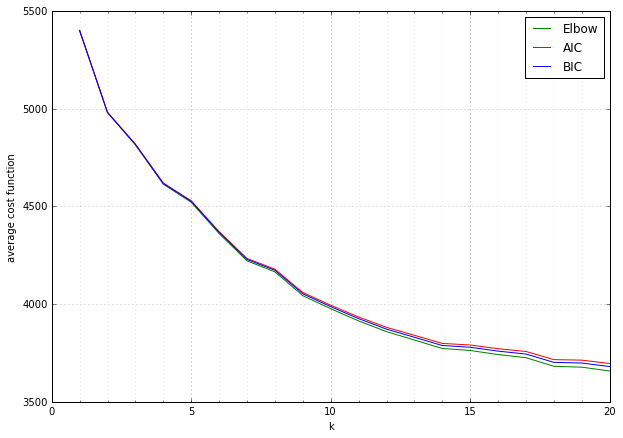

In [7]:
fig = plt.figure(figsize=(10,7))                                                               
ax = fig.add_subplot(1,1,1) 

#ax.set_xticks(major_ticks)
ax.set_xticks(np.arange(0, 21, 1), minor=True)

ax.grid(which='both')

ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.5)

ax.plot(np.arange(clusters)+1, elbow, 'g-', label="Elbow")
ax.plot(np.arange(clusters)+1, AIC, 'r-', label="AIC")
ax.plot(np.arange(clusters)+1, BIC, 'b-', label="BIC")
ax.set_xlabel('k')
ax.set_ylabel('average cost function')
ax.legend()
fig.savefig('AIC_BIC.png', dpi=100)

## 이하는 연습

# 아마 아래쪽은 연습한 것 일거다.

In [ ]:
print(np.shape(W))

In [ ]:
# get indices of clusters for each data
cluster_idx = []
for data in range(m):
    min_vals = []
    for weight in range(clusters_num):
        diff = W[weight, :] - train[:, data]
        min_vals.append(sum(np.square(diff)))

    min_idx = np.argmin(min_vals)
    cluster_idx.append(min_idx)

# get True and False
for i in range(clusters_num):
    cluster_map = np.array(cluster_idx) == i

    # make matrix of True and False for mapping
    cluster = cluster_map
    for j in range(14):
        cluster = np.vstack((cluster, cluster_map))
    #print(np.shape(train[cluster].reshape(n, -1)))
    
    for k in range(clusters_num):
        clt = "cluster{0}".format(i)
        globals()[clt]=train[cluster].reshape(n, -1)
    print("cluster{0}: ".format(i), np.shape(eval("cluster{0}".format(i))))

In [ ]:
diff_sum = [] # all differences of clusters
for c in range(clusters_num):
    diff_vals = [] # difference for one cluster
    clt = "cluster{0}".format(c)
    [n2, m2] = np.shape(eval(clt))
    for data in range(m2):
        diff = np.square(eval(clt)[:, data] - W[c, :])
        diff_vals.append(np.sum(diff))

    diff_sum.append(np.sum(diff_vals))

#print(np.shape(diff_sum))
print("Total loose of {0} cluster: {1}".format(clusters_num, np.sum(diff_sum)))